# Tutorial for a `NODE` regressor

In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0,1
import os, sys
import time
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import lib_node_hong_v1 as lib
import torch, torch.nn as nn
import torch.nn.functional as F
from qhoptim.pyt import QHAdam

env: CUDA_VISIBLE_DEVICES=0,1


In [2]:
%%time
data = lib.Dataset("YEAR", random_state=111, quantile_transform=True, quantile_noise=1e-3)

CPU times: user 10.4 s, sys: 812 ms, total: 11.3 s
Wall time: 11.3 s


#### Initialize device

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")
print(f"Using {torch.cuda.device_count()} GPUs!")
print(f"Torch Version: {torch.__version__} ")

Using cuda device
Using 2 GPUs!
Torch Version: 2.2.0+cu121 


In [4]:
# I will use the first gpu card, `cuda:0'
device = 'cuda:0'

In [5]:
experiment_name = 'year_node_shallow'
experiment_name = '{}_{}.{:0>2d}.{:0>2d}_{:0>2d}:{:0>2d}'.format(experiment_name, *time.gmtime()[:5])
print("experiment:", experiment_name)

experiment: year_node_shallow_2024.08.02_07:42


### Quick EDA of trainset

In [6]:
in_features = data.X_train.shape[1]

mu, std = data.y_train.mean(), data.y_train.std()
normalize = lambda x: ((x - mu) / std).astype(np.float32)
data.y_train, data.y_valid, data.y_test = map(normalize, [data.y_train, data.y_valid, data.y_test])

print("mean = %.5f, std = %.5f" % (mu, std))

mean = 1998.39193, std = 10.92832


In [7]:
print(in_features)

90


### Set model and Fit

In [8]:
model = nn.Sequential(
    lib.DenseBlock(in_features, 128, num_layers=1, tree_dim=3, depth=4, flatten_output=False,
                   choice_function=lib.entmax15, bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average first channels of every tree
    
).to(device)

with torch.no_grad():
    res = model(torch.as_tensor(data.X_train[:1000], device=device))
    # trigger data-aware init

# Dead-Lock    
#if torch.cuda.device_count() > 1:
#    model = nn.DataParallel(model)

In [9]:
from qhoptim.pyt import QHAdam
optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }

In [10]:
trainer = lib.Trainer(
    model=model, loss_function=F.mse_loss,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=optimizer_params,
    verbose=True,
    n_last_checkpoints=5
)

In [11]:
from tqdm import tqdm
from IPython.display import clear_output
loss_history, mse_history = [], []
best_mse = float('inf')
best_step_mse = 0
early_stopping_rounds = 500
report_frequency = 100

In [12]:
data.X_test.shape,data.X_train.shape,data.X_valid.shape

((51630, 90), (370972, 90), (92743, 90))

In [13]:
data.y_test.shape,data.y_train.shape,data.y_valid.shape

((51630,), (370972,), (92743,))

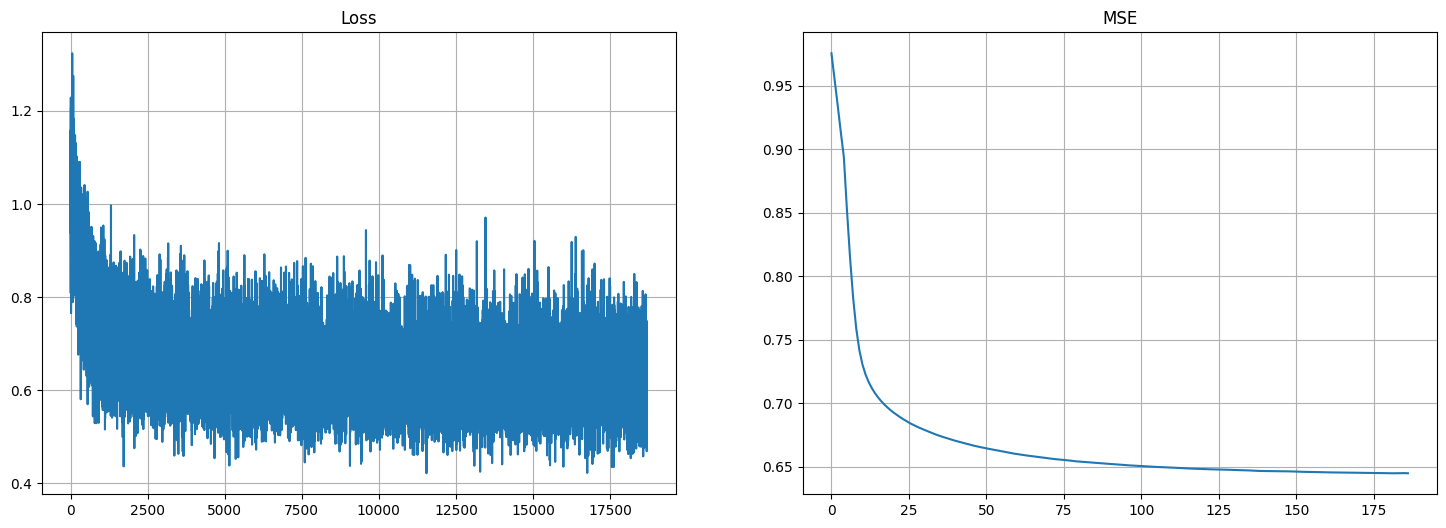

Loss 0.71783
Val MSE: 0.64477
BREAK. There is no improvment for 500 steps
Best step:  18200
Best Val MSE: 0.64475
CPU times: user 1min 32s, sys: 24.3 s, total: 1min 56s
Wall time: 1min 29s


In [14]:
%%time
for batch in lib.iterate_minibatches(data.X_train, data.y_train, batch_size=512, 
                                                shuffle=True, epochs=100):
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        mse = trainer.evaluate_mse(
            data.X_valid, data.y_valid, device=device, batch_size=1024)

        if mse < best_mse:
            best_mse = mse
            best_step_mse = trainer.step
            trainer.save_checkpoint(tag='best_mse')
        mse_history.append(mse)
        
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()

        clear_output(True)
        plt.figure(figsize=[18, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.title('Loss')
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.plot(mse_history)
        plt.title('MSE')
        plt.grid()
        plt.show()
        print("Loss %.5f" % (metrics['loss']))
        print("Val MSE: %0.5f" % (mse))
    if trainer.step > best_step_mse + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step_mse)
        print("Best Val MSE: %0.5f" % (best_mse))
        break

In [15]:
trainer.load_checkpoint(tag='best_mse')
mse = trainer.evaluate_mse(data.X_test, data.y_test, device=device)
print('Best step: ', trainer.step)
print("Test MSE: %0.5f" % (mse))

Loaded logs/year_node_shallow_2024.08.02_07:42/checkpoint_best_mse.pth
Best step:  18200
Test MSE: 0.65637


In [16]:
mse * std ** 2

78.3888507540874